# Analysis of Hurricane Data - A Case Study of Atlantic Hurricanes

## Loading the libraries

In [1]:
# For data munging and analysis
library(tidyverse)

# For parsing the html tables from the internet
library(rvest)

# Need to fit the data to various distributions
library(fitdistrplus)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0.9000     ✔ purrr   0.2.5     
✔ tibble  1.4.2          ✔ dplyr   0.7.6     
✔ tidyr   0.8.1          ✔ stringr 1.3.1     
✔ readr   1.2.0          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xml2

Attaching package: ‘rvest’

The following object is masked from ‘package:purrr’:

    pluck

The following object is masked from ‘package:readr’:

    guess_encoding

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei


## Converting  years to decades

In [2]:
# Generate a hurricane decade list to segment our hurricane data into the 
# corresponding decades
hurricane_decades <- c()
hurricane_decade_year <- 1850
while (hurricane_decade_year <= 2020){
  hurricane_decades = c(hurricane_decades, hurricane_decade_year)
  hurricane_decade_year = hurricane_decade_year + 10
}

In [3]:
convert_seasons_to_decade <- function(x){
  index <- 1
  while((index + 1) <= length(hurricane_decades)){
    
    if (x >= hurricane_decades[[index]] && \
        x< hurricane_decades[[index + 1]]){
      return(hurricane_decades[[index]])
    }
    index <- index + 1
  }
}

## Parsing the html tables and process them

In [4]:
# Function to get the html table given a url
get_html_table <- function(url){
  hurricane_table <- url %>% 
    read_html %>%
    html_nodes("table")
  
  return(hurricane_table)
}

In [5]:
# Function to process category 4 hurricane tables
process_category_4_hurricane_tables <- function(category_4_hurricane_tables){
  processed_hurricane_tables <- c()

# There are 5 different tables on the page and we get all of them by 
# iterating through the raw hurricane table data from that page.
  for (index in 2:6){
    
    # First get the raw table
    hurricane_table <- html_table(category_4_hurricane_tables[index], fill = T)[[1]]
    
    # The first row contains the column names, so we remove it
    hurricane_table <- hurricane_table[-1, ]
    
    # The last row also contains some unnecessary information, 
    # so we remove the last row
    hurricane_table <- head(hurricane_table, -1)
    
    # Get only the Season column
    hurricane_table <- hurricane_table[c("Season")]
    
    # Convert the Seasons to decades
    hurricane_table$Season_decade <- unlist(lapply(hurricane_table$Season, 
                                                   convert_seasons_to_decade))
    
    # Group by Season_decade and sum the counts
    hurricane_table$one_column = 1
    hurricane_table <- hurricane_table %>%
      group_by(Season_decade) %>%
      summarise(
        total_hurricanes = sum(one_column)
      )
    
    # Append the tables to the final list
    processed_hurricane_tables[[index]] <- hurricane_table
  }
  
  # Different tables contain the row for the same decade and 
  # hence we carry out a final group_by operation on the final processed
  # table to get the final hurricane counts.
  processed_hurricane_tables <- bind_rows(processed_hurricane_tables)
  processed_hurricane_tables <- processed_hurricane_tables %>%
      group_by(Season_decade) %>%
      summarise(
        total_hurricanes = sum(total_hurricanes)
      )
  return(processed_hurricane_tables)
}

In [6]:
# Function to process category 5 hurricane tables
process_category_5_hurricane_tables <- function(category_5_hurricane_tables){
  
  # First get the raw table
  hurricane_table <- html_table(category_5_hurricane_tables[2], fill = T)[[1]]
  
  # The first row contains the column names, so we remove it
  hurricane_table <- hurricane_table[-1, ]
  
  # The last row also contains some unnecessary information, 
  # so we remove the last row
  hurricane_table <- head(hurricane_table, -1)
  
  hurricane_table <- hurricane_table[c("Dates as aCategory 5")]
  colnames(hurricane_table) <- c("Dates")
  
  # Split the dates on space and get the 3rd element in the split 
  # list because that is the year in the date.
  hurricane_table$Dates <- strsplit(hurricane_table$Dates, ' ')
  
  # lapply returns a list and so we unlist/unpack the list to get the numbers
  hurricane_table$Season <- unlist(lapply(hurricane_table$Dates, 
                                          function(x) x[[3]]))
  
  # Convert the Seasons to decades
  hurricane_table$Season_decade <- unlist(lapply(hurricane_table$Season, 
                                                 convert_seasons_to_decade))
  
  # Group by Season_decade and sum the counts
  hurricane_table$one_column = 1
  hurricane_table <- hurricane_table %>%
    group_by(Season_decade) %>%
    summarise(
      total_hurricanes = sum(one_column)
    )
  
  return(hurricane_table)
}

## Get the html tables and convert to final processed dataframes

In [7]:
#URLs
wiki_url_for_category_4_hurricanes <- "https://en.wikipedia.org/wiki/List_of_Category_4_Atlantic_hurricanes"
wiki_url_for_category_5_hurricanes <- "https://en.wikipedia.org/wiki/List_of_Category_5_Atlantic_hurricanes"

In [8]:
# Fetching the Hurricane Tables
category_4_hurricane_tables <- get_html_table(wiki_url_for_category_4_hurricanes)
category_5_hurricane_tables <- get_html_table(wiki_url_for_category_5_hurricanes)

In [9]:
# Process the raw html tables and convert them to the structure needed
final_category_4_hurricane_table <- process_category_4_hurricane_tables(
    category_4_hurricane_tables)
final_category_5_hurricane_table <- process_category_5_hurricane_tables(
    category_5_hurricane_tables)

# Combine both the tables
final_combined_hurricane_table <- bind_rows(final_category_4_hurricane_table, 
                                            final_category_5_hurricane_table)

## Analysing probability distributions
We will use the dpois() function of R to model the probability distributions of our hurricane data. If we have the following code:

**dpois(x = 1, lambda = lambda_for_category_4_hurricanes)**

This is the *Probability of 1 category-4 hurricane occuring in a decade when the mean hurricane rate is equal to the mean category-4 hurricanes.*

Similarly, we can calculate the probability of *n* category-4 hurricanes occuring in a decade.

In [10]:
lamba_for_category_4_hurricanes <- mean(
    final_category_4_hurricane_table$total_hurricanes)
lamba_for_category_5_hurricanes <- mean(
    final_category_5_hurricane_table$total_hurricanes)
lambda_for_combined_hurricanes <- mean(
    final_combined_hurricane_table$total_hurricanes)

In [11]:
get_poisson_probabilities <- function(lambda){
    
    poisson_probabilities <- c()
    for (i in 1:50){
        
      # Probability of exactly *i* hurricanes occuring in a decade
      poisson_probabilities[i] <- dpois(i, lambda = 7)
    }

    poisson_probabilities_df <- as.data.frame(poisson_probabilities)
    poisson_probabilities_df$num_hurricanes_in_the_decade <- c(1:50)
    colnames(poisson_probabilities_df) <- c("poisson_probabilities", 
                                            "number_of_hurricanes")
    
    return(poisson_probabilities_df)
}

category_4_poisson_probabilities_df <- get_poisson_probabilities(
    lambda = lamba_for_category_4_hurricanes)
category_5_poisson_probabilities_df <- get_poisson_probabilities(
    lambda = lamba_for_category_5_hurricanes)

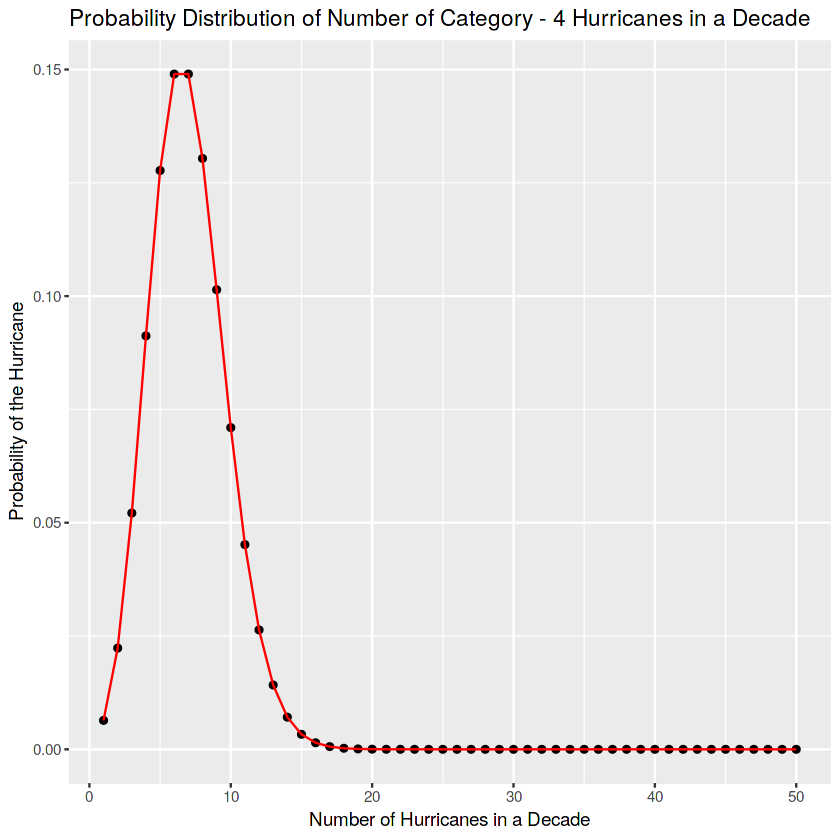

In [12]:
category_4_poisson_probabilities_df %>%
ggplot(aes(x = number_of_hurricanes, y = poisson_probabilities))+
geom_point()+
geom_line(color = "red")+
labs(x = "Number of Hurricanes in a Decade", 
     y = "Probability of the Hurricane", 
     title = "Probability Distribution of Number of Category - 4 Hurricanes in a Decade")

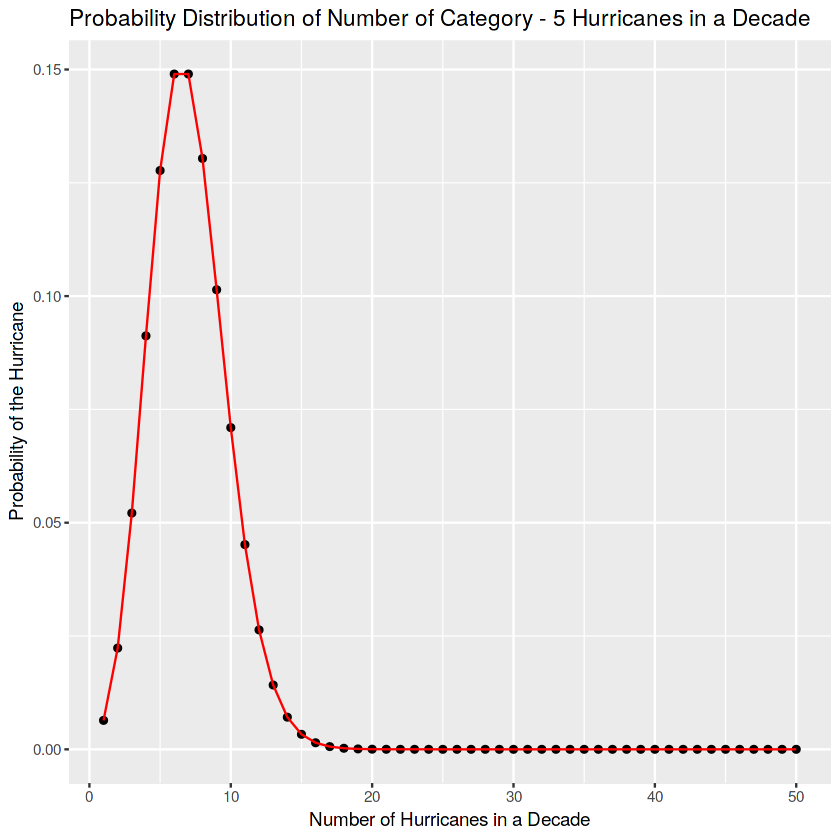

In [13]:
category_5_poisson_probabilities_df %>%
ggplot(aes(x = number_of_hurricanes, y = poisson_probabilities))+
geom_point()+
geom_line(color = "red")+
labs(x = "Number of Hurricanes in a Decade", 
     y = "Probability of the Hurricane", 
     title = "Probability Distribution of Number of Category - 5 Hurricanes in a Decade")

We observe that the probability of a hurricane occuring (for both categories), shows a distribution similar to a Poisson Distribution.

## Analysing the cumulative probability distribution
Let us look at another function:

**ppois(x = n, lambda = lambda_for_category_4_hurricanes)**

This function gives us the "Probability of *n or fewer hurricanes* occuring in a decade when the rate is the mean category-4 hurricanes". Lets plot it

In [14]:
get_ppois_poisson_probabilities <- function(lambda){
    
    poisson_probabilities <- c()
    for (i in 1:50){
      # Probability of *i* or less hurricanes occuring in a decade
      poisson_probabilities[i] <- ppois(i, lambda = lambda)
    }

    poisson_probabilities_df <- as.data.frame(poisson_probabilities)
    poisson_probabilities_df$num_hurricanes_in_the_decade <- c(1:50)
    colnames(poisson_probabilities_df) <- c("poisson_probabilities", 
                                            "number_of_hurricanes")
    
    return(poisson_probabilities_df)
}

category_4_ppois_poisson_probabilities_df <- get_ppois_poisson_probabilities(
    lambda = lamba_for_category_4_hurricanes)
category_5_ppois_poisson_probabilities_df <- get_ppois_poisson_probabilities(
    lambda = lamba_for_category_5_hurricanes)

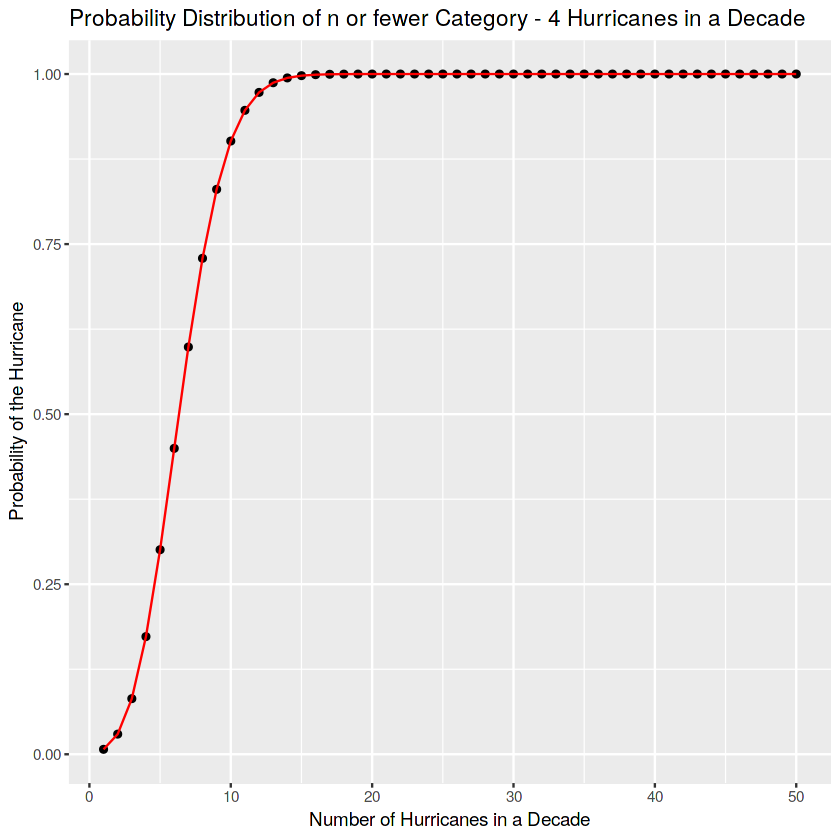

In [15]:
category_4_ppois_poisson_probabilities_df %>%
ggplot(aes(x = number_of_hurricanes, y = poisson_probabilities))+
geom_point()+
geom_line(color = "red")+
labs(x = "Number of Hurricanes in a Decade", 
     y = "Probability of the Hurricane", 
     title = "Probability Distribution of n or fewer Category - 4 Hurricanes in a Decade")

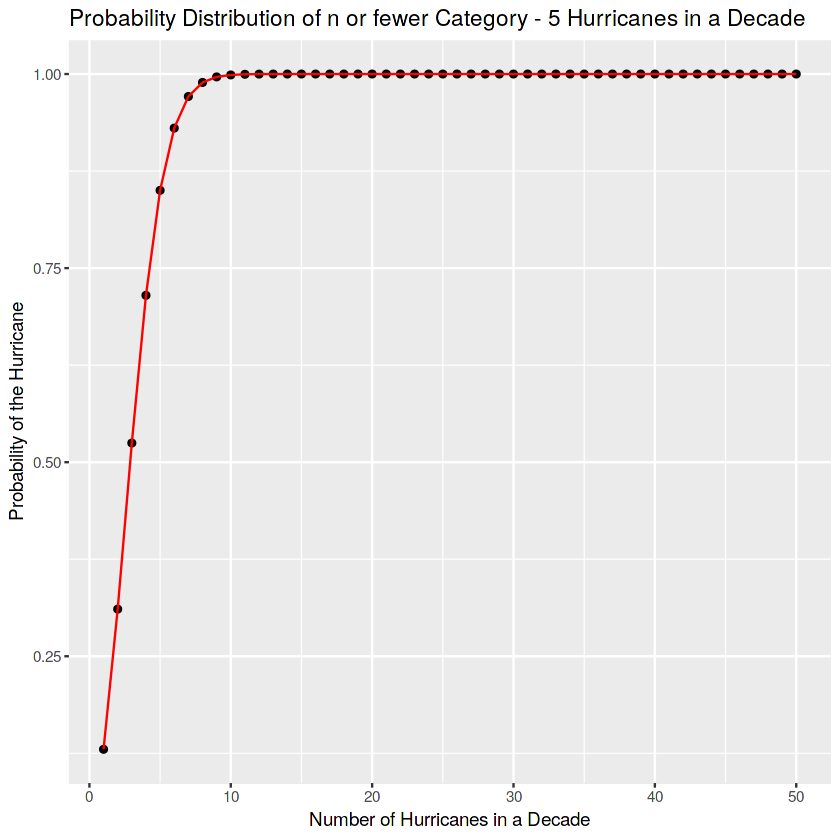

In [16]:
category_5_ppois_poisson_probabilities_df %>%
ggplot(aes(x = number_of_hurricanes, y = poisson_probabilities))+
geom_point()+
geom_line(color = "red")+
labs(x = "Number of Hurricanes in a Decade", 
     y = "Probability of the Hurricane", 
     title = "Probability Distribution of n or fewer Category - 5 Hurricanes in a Decade")

## Is it an exact Poisson distribution?

Although the plots look similar to a Poisson distribution, we cannot assume that the data is indeed a Poisson distribution by looking at the plots. Poisson distribution has a property that the mean and variance are equal and we use this property to test the fit of our data. Wecheck if this property is satisfied or *almost satisfied* by our data. We compute the ratio of mean and variance of our data:

In [17]:
variance_of_cat_4_hurricanes <- var(
    final_category_4_hurricane_table$total_hurricanes)
mean_of_cat_4_hurricanes <- mean(
    final_category_4_hurricane_table$total_hurricanes)

variance_mean_ratio_for_category_4_hurricanes <- round(
    variance_of_cat_4_hurricanes/mean_of_cat_4_hurricanes, 2)
variance_mean_ratio_for_category_4_hurricanes

[1] 2.82

We see that the variance of our data is 2.82 times larger than the mean of the data. We check if such a behaviour is normal or not for a poisson distribution. We check if this is just a one time anomaly or is it recurring or not. We will perform a **Monte Carlo Simulation** and repeatedly sample values from the poisson distribution with the mean/lambda equal to the mean of the hurricane data. Our main aim of the simulation is to check -

*Assuming that the category 4 hurricane data is a perfect Poisson distribution, how likely it is for us to generate samples with a variance-to-mean ratio equal to 2.82*

In [18]:
set.seed(420)
variance_mean_ratio_from_samples <- c()
num_of_monte_carlo_simulations <- 1000
num_of_points_in_sample <- nrow(final_category_4_hurricane_table)

for (monte_carlo_experiment_index in  1:num_of_monte_carlo_simulations){
    poisson_sample <- rpois(n = num_of_points_in_sample, 
                            lambda = lamba_for_category_4_hurricanes)
    variance_mean_ratio_from_samples[[monte_carlo_experiment_index]] <- var(
        poisson_sample)/mean(poisson_sample)
}

percentage_of_samples_with_variance_mean_ratio_greater_than_2.82 <- sum(
    variance_mean_ratio_from_samples > \
    variance_mean_ratio_for_category_4_hurricanes)*100/num_of_monte_carlo_simulations
percentage_of_samples_with_variance_mean_ratio_greater_than_2.82

[1] 0.1

This shows that only 0.1% of the monte carlo samples have a variance-mean ratio greater than 2.82. Hence, the hurricane count in a decade does not exhibit an exact Poisson process and the variability in hurricane counts is higher than a Poisson distribution with constant rate. This means that for a distribution of hurricane counts in a decade, the lambda/rate is not constant but keeps changing.

## Reasons for the varying lambda/rate in hurricane data

The reasons for the non-constant rate/lambda in our hurricane data is because external climatic conditions affect the occurence of hurricane and ultimately change the lambda. These external factors could be **changes in pressure, wind speeds, El Nino etc...** This leads to hurricane data being a varying Poisson distribution or an **inhomogeneous Poisson distribution** which can be described as a Poisson distribution with a variable rate/lambda.

## Analysing QQ Plot
Quantile plots are a good way to look at what distribution a data might belong to.  Here, we plot a quantile plot of our hurricane data (using the category-4 data again) and quantiles drawn from a theoretical Poisson distribution.

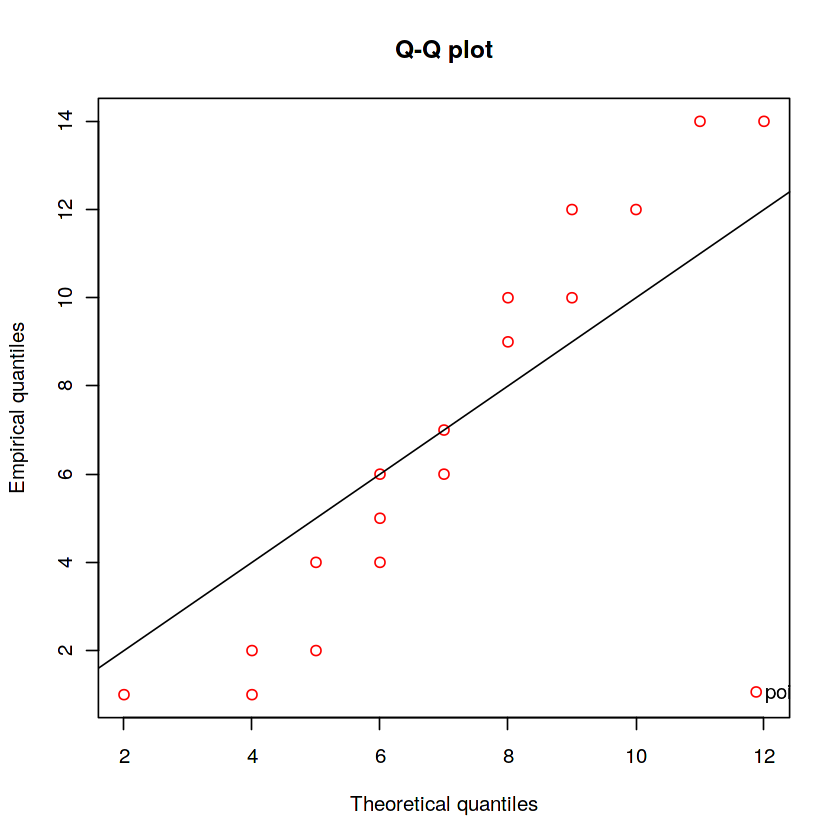

In [19]:
qqcomp(fitdist(final_category_4_hurricane_table$total_hurricanes, "pois"))

The quantile plot strengthens our conclusion that our hurricane data is not entirely a Poisson distribution with a constant rate. What if we use a negative binomial distribution for this?

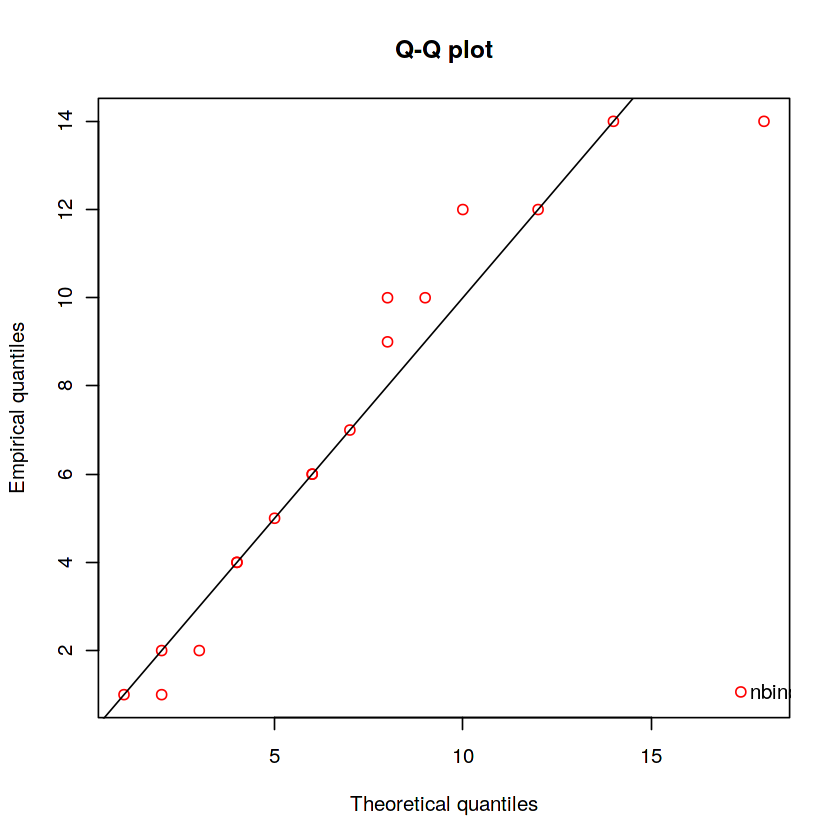

In [20]:
qqcomp(fitdist(final_category_4_hurricane_table$total_hurricanes, "nbinom"))

This shows that the hurricane count data infact is similar to a **negative binomial distribution**. Poisson distributions are special cases of negative binomial distributions and our above distribution is a case of **overdispersed Poisson distribution**. In an overdispersed Poisson distribution, the observations are overdispersed in comparison to a theoretical Poisson distribution where variance is equal to the mean. This overdispersion causes the variance of the data to be greater than the mean - which is the case for our hurricane data. Such overdispersion can be reduced by varying the variance and keeping the mean constant. Since negative binomial distributions have one more parameter than a Poisson distribution, we can vary the parameter to adjust the variance keeping the mean constant.



*References for the above explanation - *

[1] https://stats.stackexchange.com/questions/32035/checking-poisson-distribution-plot-using-mean-and-variance-relationship

[2] https://en.wikipedia.org/wiki/Negative_binomial_distribution#Overdispersed_Poisson

## Analysing the variables - an exploratory data analysis
Having

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


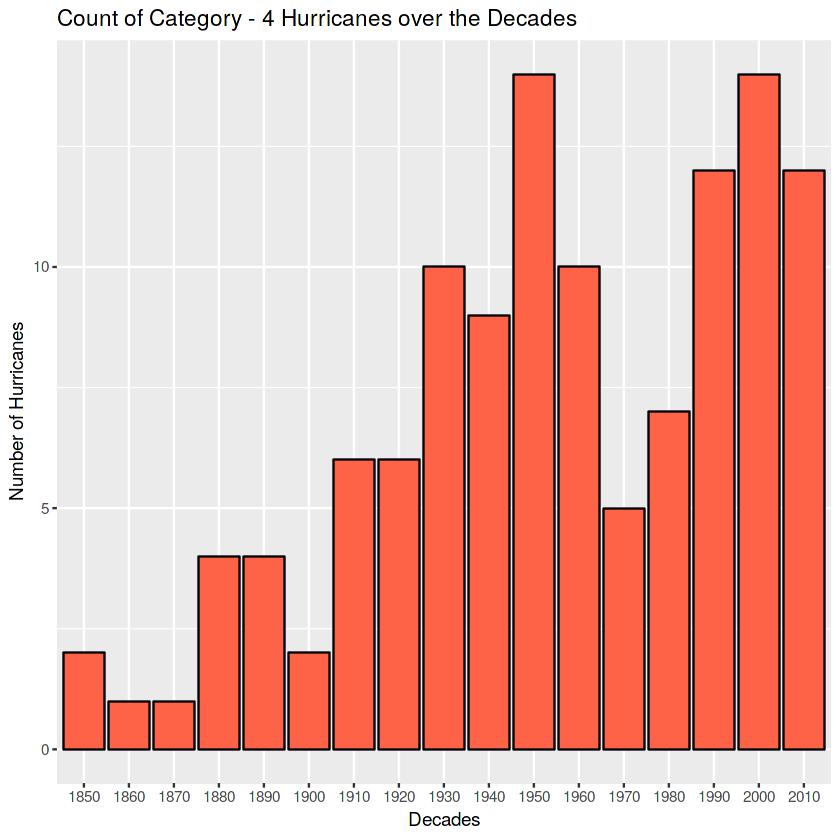

In [21]:
final_category_4_hurricane_table %>%
ggplot(aes(as.factor(Season_decade), total_hurricanes))+
geom_bar(stat = "identity", color = "black", fill = "tomato")+
geom_line()+
labs(x = "Decades", 
     y = "Number of Hurricanes", 
     title = "Count of Category - 4 Hurricanes over the Decades")

We see that the number of category-4 hurricanes occuring in a decade has increased with time gradually.

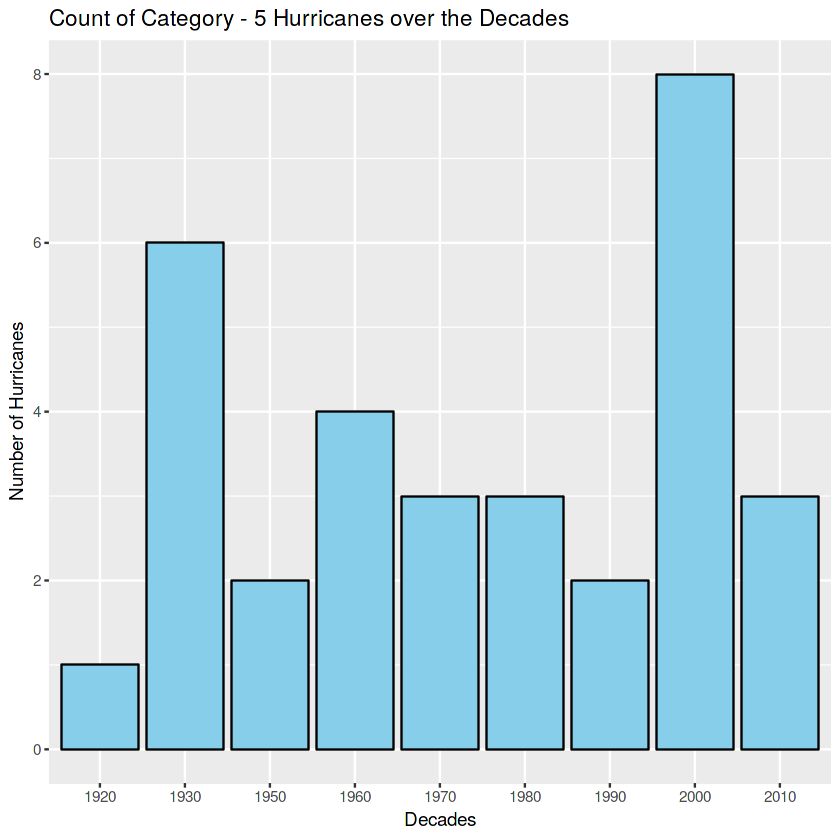

In [22]:
final_category_5_hurricane_table %>%
ggplot(aes(as.factor(Season_decade), total_hurricanes))+
geom_bar(stat = "identity", color = "black", fill = "skyblue")+
labs(x = "Decades", 
     y = "Number of Hurricanes", 
     title = "Count of Category - 5 Hurricanes over the Decades")

However, in the case of category-5 hurricanes, the distribution/count of hurricanes is not 

Now, let us upload the whole raw data and clean it again to draw some more analysis. (Till now, the dataset we were working on was decade level)

In [23]:
# Load whole of csv data and not just decade wise
category_4 = read.csv("../input/category-4/Category4Hurricanes - Sheet1.csv", 
                      header = TRUE)
category_5 = read.csv("../input/category-5/Category5Hurricanes - Sheet1.csv", 
                      header = TRUE)

In [24]:
# Changing column names for cateogry_4 dataset
colnames(category_4) <- c("Name", "Season", "Month", "Max_wind_knots", 
                          "Max_wind_kmh", "Max_wind_mph", "Min_pressure_mbar")

# Changing column names for cateogry_5 dataset
colnames(category_5) <- c("Name", "Dates", "Duration_hours", "WindSpeedsMPH", 
                          "PressurehPA", "Affected_Areas", "Deaths", 
                          "DamageUSDMillions")

# Clean month column for Category 4
category_4$Month <- gsub(" .*$", "",category_4$Month)
category_4$Month <- gsub(",", "", category_4$Month)

# Clean min_pressure column for Category 4
from <- c("≤ ","-", "–")
to <- c("")

gsub_func <- function(pattern, replacement, x) {
  for(i in 1:length(pattern))
    x <- gsub(pattern[i], replacement[i], x)
  x
}

category_4$Min_pressure_mbar <- as.numeric(
    gsub_func(from, to, category_4$Min_pressure_mbar))

#  Clean Category 5 data
category_5$Dates <- gsub(
    "†", "", category_5$Dates)
category_5$Year <- as.numeric(
    gsub(".+, ", "", category_5$Dates))
category_5$Month <- gsub(
    "[0-9, ].+", "", category_5$Dates)
category_5$DamageUSDMillions <- gsub(
    ">", "", category_5$DamageUSDMillions)
category_5$WindSpeedsMPH <- as.numeric(
    gsub("([0-9]+).*", "\\1", category_5$WindSpeedsMPH))
category_5$PressurehPA <- as.numeric(
    gsub("([0-9]+).*", "\\1", category_5$PressurehPA))

category_5$DamageUSDMillions <- gsub(
    "([0-9]+).*", "\\1", category_5$DamageUSDMillions)
category_5$DamageUSDMillions <- gsub(
    "Extensive", "", category_5$DamageUSDMillions)
category_5$DamageUSDMillions <- as.numeric(
    gsub("\\$", "", category_5$DamageUSDMillions))

head(category_4)
head(category_5)

Name,Season,Month,Max_wind_knots,Max_wind_kmh,Max_wind_mph,Min_pressure_mbar
Hurricane #3,1853,August,130,240,150,924
"""1856 Last Island Hurricane""",1856,August,130,240,150,934
Hurricane #6,1866,September,120,220,140,938
Hurricane #7,1878,September,120,220,140,938
Hurricane #2,1880,August,130,240,150,931
Hurricane #8,1880,September,120,220,140,928


Name,Dates,Duration_hours,WindSpeedsMPH,PressurehPA,Affected_Areas,Deaths,DamageUSDMillions,Year,Month
"""Cuba""","October 19, 1924",12,165,910,"Central America, Mexico, CubaFlorida, The Bahamas",90,NA,1924,October
"""San Felipe IIOkeechobee""","September 13–14, 1928",12,160,929,"Lesser Antilles, The BahamasUnited States East Coast, Atlantic Canada",4000,100,1928,September
"""Bahamas""","September 5–6, 1932",24,160,921,"The Bahamas, Northeastern United States",16,NA,1932,September
"""Cuba""","November 5–8, 1932",78,175,915,"Lesser Antilles, Jamaica, Cayman IslandsCuba, The Bahamas, Bermuda",3103,40,1932,November
"""Cuba–Brownsville""","August 30, 1933",12,160,930,"The Bahamas, Cuba, FloridaTexas, Tamaulipas",179,27,1933,August
"""Tampico""","September 21, 1933",12,160,929,"Jamaica, Yucatán Peninsula",184,5,1933,September


After cleaning the data, we can try drawing correlation between integer/numerical type columns.
For category 4 data, 3 of the 4 numerical columns are of speed(in different notations), so it is obvious that they will be highly correlated (~1).
The important correlation is between speed and pressure. In our findings, there is a negative correlation between them, which can be justified according to http://ww2010.atmos.uiuc.edu/(Gh)/guides/mtr/hurr/stages/cane/pswd.rxml .


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



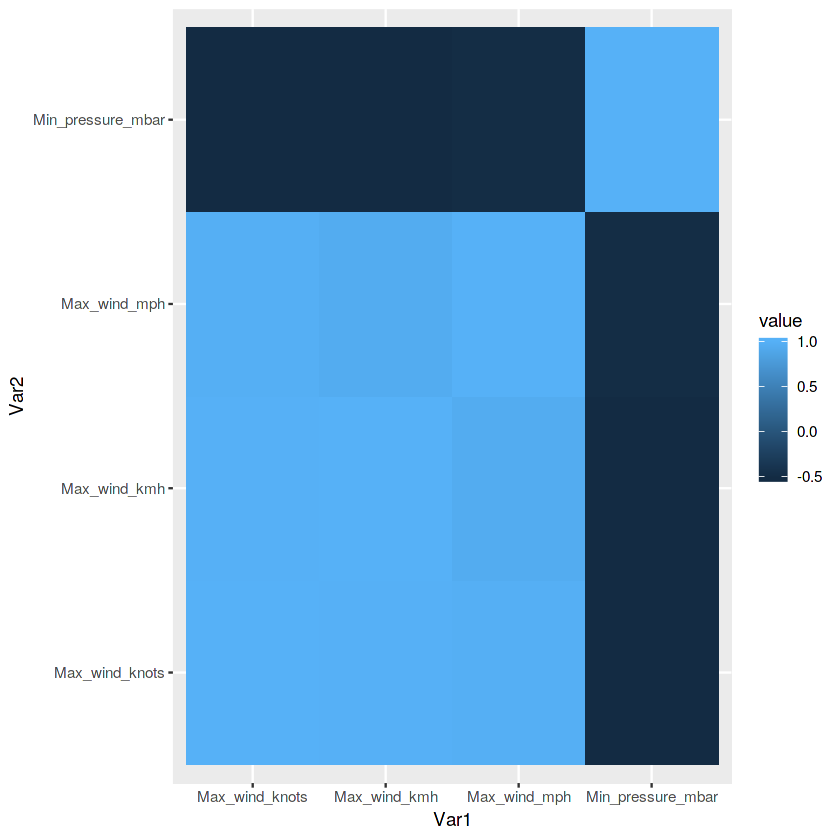

In [25]:
library(reshape2)
cormat <- cor(category_4[, c("Max_wind_knots", "Max_wind_kmh", 
                             "Max_wind_mph", "Min_pressure_mbar")], 
              use = "complete.obs", method = "pearson")
melted_cormat <- melt(cormat)

ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + geom_tile()

For category 5, below is the correlation matrix. Here also, wind speed and pressure are negatively correlated.

In [ ]:
cormat5 <- cor(category_5[, c("Duration_hours", "WindSpeedsMPH", 
                              "PressurehPA", "Deaths", "DamageUSDMillions")], 
               use = "complete.obs", method = "pearson")
melted_cormat5 <- melt(cormat5)

ggplot(data = melted_cormat5, aes(x=Var1, y=Var2, fill=value)) + geom_tile()